<a href="https://colab.research.google.com/github/G-Vida/Machine_Learning/blob/main/Copia_di_Esercitazione_Trasfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLME: Transfer Learning for Computer Vision
==============================================
### We can achiee good results even if we don't have huge capacities for training!!!



**Inspired by**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning.

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.
-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.


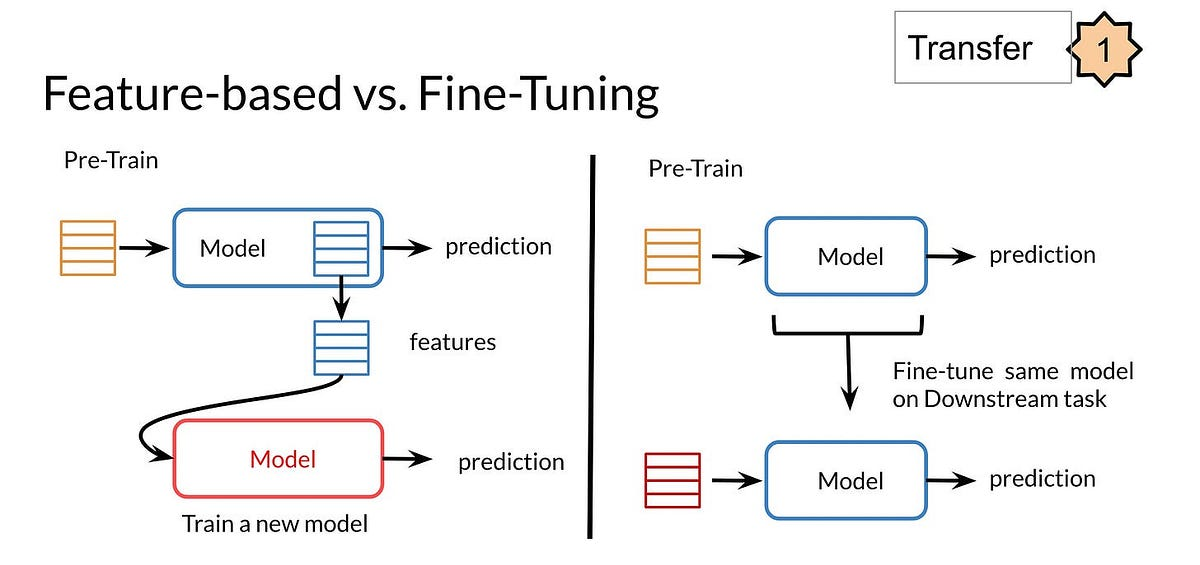

In feature-based models we use the pre-trained NN for feature extractions!!! then we train our model on top of those features => The model that we are useing to extract features is FREEZED (we don't change it)
<br><br>
In fine-tuning instead we are updating the weights of the whole model (we are not freezing the feature extraction model)
<br><br>
Usually the feature extraction models are pre-trained in generic tasks and then we use them on a more specific task/dataset (=called DOWNSTREAM TASK). We are restricting what we want to do with our model.

# Let's introduce it

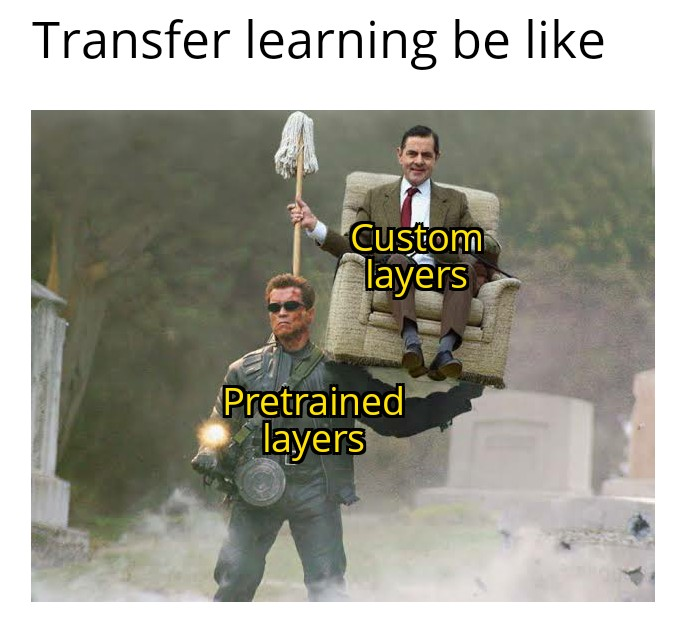

# Some basic imports

In [1]:
### Always remember to connect to a GPU RUNTIME at the beggining!!! ###

# License: BSD
# Author: Sasank Chilamkurthy
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")   ### If we are using the cuda device is good!!!

Using cuda device


In [3]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [4]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

Cloning into 'ants-bees-dataset'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408 (from 1)
Receiving objects: 100% (408/408), 45.03 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {             ### To have different immages fro our model => AUGMENTATION => If we change the semantic meaning we should not do the changes, but otherwise yes!
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/ants-bees-dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),                  ### We are passing the folder of the images (it will do everything for us and the loading)
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,        ### We create a data loader
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


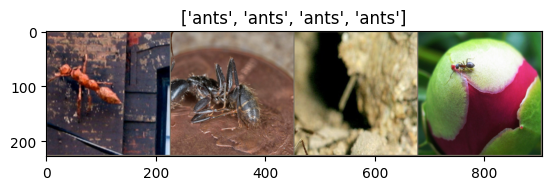

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [7]:
from logging import logProcesses
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)      ### We save the model at the beggining bit torch.save
        best_acc = 0.0                                              ### We will keep track of the best accuracy

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:      ### We have both the training and valdiation part
                if phase == 'train':
                    model.train()  # Set model to training mode => Meaning that we caluclate all the gradients and we have backpropagation
                else:
                    model.eval()   # Set model to evaluate mode => Meaning that everything is FREAZED

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):     ### we take the prediticions of the model
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()        ### We have the backward if we are in the training case
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)     ### Number of the correct ones
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:       ### If the phase is validation, we need to understand if the new step is doing better and if it is true we refresh the best accuracy and save the model
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()


        ### It's important top consider the TIME!!!
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, time_elapsed, best_acc

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [8]:
def visualize_model(model, num_images=6):      ### To visualize the model predictions
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():  ### This is very important to set no_grad() so the model is not going to compute the gradients
        for i, (inputs, labels) in enumerate(dataloaders['val']):      ### We iterate on data loader and print some images
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, label: {class_names[labels[j]]}')     ### We add the class names to the true labels and predicted ones
                imshow(inputs.cpu().data[j])                   ### We always have to moove it to the CPU!!!

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [ ]:
### FINE-TUNING PART ###
model_ft = models.resnet18(weights='IMAGENET1K_V1')    ### We load the pre-trained weights that are already available, we consider resnet18 (is the smallest backbopne we can use (with a better gpu/time we might use a different one, this is the more lightweighted))
num_ftrs = model_ft.fc.in_features
### This model was not specifically trained on our downstream task (= binary classification => bee or ant), but no model was only trained on those 2

print(model_ft)   ### we can print how this is done/the whole information flow/each passage
### Badic blocks are implemented with skip-conncections / residual connections => we help the last layers to learn some useful staff avoiding he gradient banishing problem

### At the end the long list has:
# - we have and ADAPTIVE AVERAGE POOL (adaptive meaning that we don't need to care about the sizes)
# - We have LINEAR

In [ ]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [10]:
model_ft, time_elapsed_ft, best_acc_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4763 Acc: 0.7623
val Loss: 0.2914 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5321 Acc: 0.7828
val Loss: 0.7103 Acc: 0.7255

Epoch 2/24
----------
train Loss: 0.4164 Acc: 0.8156
val Loss: 0.2827 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.6098 Acc: 0.7664
val Loss: 0.2536 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3981 Acc: 0.8443
val Loss: 0.2443 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5356 Acc: 0.7705
val Loss: 0.2554 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3738 Acc: 0.8361
val Loss: 0.7179 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.3788 Acc: 0.8197
val Loss: 0.2467 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.1895 Acc: 0.9385
val Loss: 0.2499 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2837 Acc: 0.8811
val Loss: 0.2832 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3427 Acc: 0.8648
val Loss: 0.2155 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3334 Acc: 0.8443
val Loss: 0.3242 Acc: 0.8954

Ep

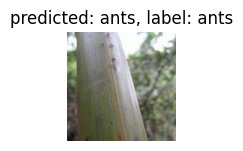

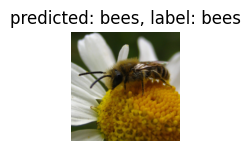

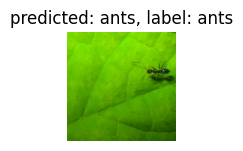

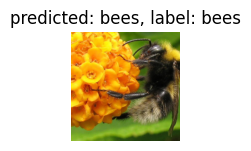

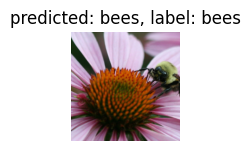

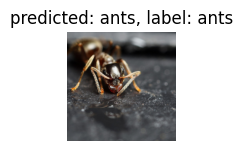

In [11]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [13]:
model_conv, time_elapsed_conv, best_acc_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7086 Acc: 0.5328
val Loss: 0.5583 Acc: 0.6993

Epoch 1/24
----------
train Loss: 0.5924 Acc: 0.6639
val Loss: 0.4172 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5104 Acc: 0.7746
val Loss: 0.3536 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4400 Acc: 0.8156
val Loss: 0.2990 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4421 Acc: 0.8566
val Loss: 0.3007 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4813 Acc: 0.7623
val Loss: 0.2622 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3947 Acc: 0.8320
val Loss: 0.2445 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4259 Acc: 0.8238
val Loss: 0.2423 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4470 Acc: 0.8197
val Loss: 0.2435 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4050 Acc: 0.8197
val Loss: 0.2402 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3677 Acc: 0.8484
val Loss: 0.2240 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3756 Acc: 0.8443
val Loss: 0.2307 Acc: 0.9346

Ep

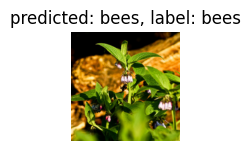

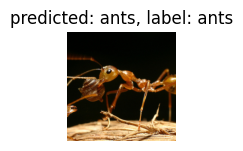

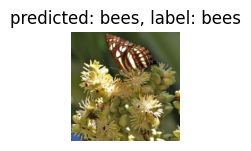

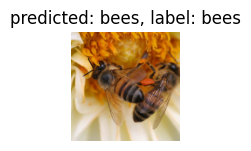

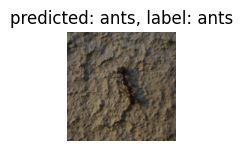

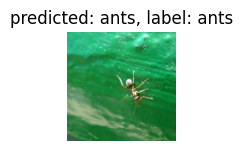

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

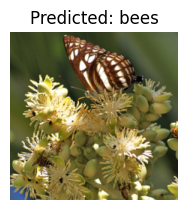

In [16]:
visualize_model_predictions(
    model_conv,
    img_path='/content/ants-bees-dataset/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Differences between the two approaches
==========================


As you can see the architecture is the same but the trainable parameters' number is way different between the 2 architectures.

In [17]:
from torchsummary import summary
summary(model_conv, image_datasets['train'][0][0].shape, batch_size=-1)  # -1 is a placeholder for any batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
summary(model_ft, image_datasets['train'][0][0].shape, batch_size=-1)  # -1 is a placeholder for any batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## What about memory?

In [19]:
import torch
import torch.nn as nn
import time

# Dummy input (e.g. for ResNet on 224x224 RGB images)
input_data = torch.randn(8, 3, 224, 224).cuda()  # batch size = 8
target = torch.randint(0, 2, (8,)).cuda()        # binary classification

criterion = nn.CrossEntropyLoss()

def test_memory(model, label):
    model.cuda()
    model.train()

    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

    # Empty cache and reset memory tracking
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start_mem = torch.cuda.memory_allocated()
    start_peak = torch.cuda.max_memory_allocated()

    start = time.time()

    # Forward
    output = model(input_data)
    loss = criterion(output, target)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    end = time.time()

    end_mem = torch.cuda.memory_allocated()
    end_peak = torch.cuda.max_memory_allocated()

    peak_diff_Mb = (end_peak - start_peak) / 2**20

    print(f"{label}")
    print(f"Epoch time: {end - start:.2f} seconds")
    print(f"Memory Allocated: {end_mem - start_mem:.2f} bytes")
    print(f"Peak Memory Used: {peak_diff_Mb:.2f} Mega bytes")
    print('-'*40)

# Run for both models
test_memory(model_ft, "🔴 Full Fine-Tuning (model_ft)")
test_memory(model_conv, "🟢 Feature Extractor (model_conv)")

🔴 Full Fine-Tuning (model_ft)
Epoch time: 0.04 seconds
Memory Allocated: 46549504.00 bytes
Peak Memory Used: 232.20 Mega bytes
----------------------------------------
🟢 Feature Extractor (model_conv)
Epoch time: 0.01 seconds
Memory Allocated: 5632.00 bytes
Peak Memory Used: 49.83 Mega bytes
----------------------------------------


In [20]:
# @title Quick recap

from IPython.display import Markdown

params_ft = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
params_conv = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)


Markdown(f"""
### 📊 Fine-Tuning vs Feature Extraction Summary

| Property               | 🧊 Feature Extraction (`model_conv`) | 🔧 Fine-Tuning (`model_ft`) |
|------------------------|--------------------------------------|-----------------------------|
| **Trainable Parameters** | {params_conv:,}                      | {params_ft:,}               |
| **Training Time**      | {time_elapsed_conv:.1f} s ⚡️         | {time_elapsed_ft:.1f} s 🔥     |
| **Final Accuracy**     | {best_acc_conv * 100:.2f}% 🟢     | {best_acc_ft * 100:.2f}% 🟢    |
| **Convergence Speed**  | ✅ Faster                            | 🚧 Slower                  |
| **Memory Usage**       | ✅  49.00 Mb                            | 🔥 188.87 Mb               |
| **Overfitting Risk**   | ✅ Lower                             | ⚠️ Higher (on small data)  |


SyntaxError: incomplete input (<ipython-input-20-43616c40339f>, line 9)

**Takeaway:** Feature extraction is a great starting point when resources or data are limited. Fine-tuning unlocks higher accuracy when you have the budget to support it.

# When is fine-tuning better then?

Fine-tuning could get greater accuracy if we give the model enough epochs to change also the backone extraction. However we need to be careful about overfitting.

In [ ]:
model_ft, _, _ = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

In this specific problem we do not observe the improvement of performances when fine-tuning the whole model.

Some of the reasons why this happens:

*   The scale of the data is very different between the data the model was trained on and the data we fine-tuned on.
*   The fine-tuning of the whole model makes it bad in generalizing.

We can try to achieve greater performances by setting the learning rate of the backbone way lower than the learning rate of the final layer.





# Finetuning with different learning rates for the backbone and the fc layer

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD([
    {'params': model_ft.fc.parameters(), 'lr': 1e-3},  # new layer
    {'params': [param for name, param in model_ft.named_parameters() if not name.startswith('fc')], 'lr': 1e-7}  # pretrained layers
], momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, time_elapsed_ft, best_acc_lr = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

# Comparing the 3 methods

In [ ]:
import matplotlib.pyplot as plt

models_names = ['Different Lr Finetune', 'Fine-tuned ResNet18', 'Feature Extraction ResNet18']
accuracies = [best_acc_lr.cpu(), best_acc_ft.cpu(), best_acc_conv.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(models_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0.94, 0.98)  # Set y-axis limit to 0-1 for accuracy
plt.show()


However this leaderboard is very specific for this task and some technique could perform better than others based on various situations.

# Training from scratch

We could also train from scratch by setting the resnet weights to *None*.
As you can see the accuracy is really hard to improve



In [ ]:
model_from_scratch = torchvision.models.resnet18(weights=None)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_from_scratch.fc.in_features
model_from_scratch.fc = nn.Linear(num_ftrs, 2)

model_conv = model_from_scratch.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_scratch = optim.SGD(model_from_scratch.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

In [ ]:
model_from_scratch, time_elapsed_scratch, best_acc_scratch = train_model(model_from_scratch, criterion, optimizer_scratch,
                         exp_lr_scheduler, num_epochs=100)